# サイコロを振って円周率を求める

サイコロを投げて出る目の値を $X$ とおく。1〜6 の値が等確率 $\frac{1}{6}$ で出るとする。このとき、$X$ の平均は $3.5$, 分散は $\frac{35}{12}$ である。$\mu = 3.5$, $\sigma = \sqrt{\frac{35}{12}}$ とおく。

サイコロを $n$ 回振ったときの出た目の合計を $S_n$ とおくと、中心極限定理から、任意の $\alpha < \beta$ に対して

$$
P\left(\alpha < \frac{S_n - n\mu}{\sigma \sqrt{n} } < \beta\right) = \int^{\beta}_{\alpha} \frac{1}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}}
$$

が成り立つ。ここで、左辺は $\alpha < \frac{S_n - n\mu}{\sigma \sqrt{n} } < \beta$ となる確率を表す。

これを用いて円周率 $\pi$ の値を求める。

In [3]:
from statistics import mean
import numpy as np
import math


# サイコロ投げの平均
MEAN = 3.5
# サイコロ投げの分散
VARIANCE = 35/12

def roll_dice() -> int:
    # 1 ~ 6 の数字をランダムに生成
    return np.random.randint(1, 7)


def sum_of_dice(times: int) -> float:
    #  times 回投げたサイコロの目の合計値を取得
    if times < 1:
        raise ValueError()
    dice_values = [roll_dice() for i in range(times)]
    return sum(dice_values)


def normalize(_sum: float, times: int) -> float:
    return (_sum - times * MEAN) / math.sqrt(times * VARIANCE)

ここで $\alpha = \beta = \frac{1}{2 \sigma\sqrt{n}}$ とおくと、$n$ が十分大きいと仮定すれば

$$
\int^{\beta}_{\alpha} \frac{1}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}} \fallingdotseq \frac{1}{\sqrt{2 \pi}} e^{-\frac{0^2}{2}} \times \frac{1}{ \sigma\sqrt{n}} = \frac{1}{\sigma \sqrt{2 \pi n}} 
$$

が成り立つ。また、$S_n - n\mu$ の取りうる値は、$n$ が偶数ならば整数値である。よって $\frac{S_n - n\mu}{\sigma \sqrt{n}}$ の取りうる値は 

$$
\cdots, \ -\frac{2}{\sigma \sqrt{n}},\ -\frac{1}{\sigma \sqrt{n}},\ 0, \ \frac{1}{\sigma \sqrt{n}},\ \frac{2}{\sigma \sqrt{n}}, \ \cdots
$$

となる。従って

$$
P\left(-\frac{1}{2 \sigma\sqrt{n}} \leq \frac{S_n - n \mu}{\sigma \sqrt{n} } < \frac{1}{2 \sigma\sqrt{n}} \right) = P\left(\frac{S_n - n\mu}{ \sigma\sqrt{n} } = 0 \right)
$$

となる。中心極限定理から

$$
P\left(S_n = n \mu \right) = P\left(\frac{S_n - n\mu}{ \sigma\sqrt{n} } = 0 \right) \fallingdotseq \frac{1}{\sigma \sqrt{2 \pi n}} 
$$

が成り立つ。

よってサイコロを $n$ 回振る試行を $M$ 回行い、$S_n = n\mu$ となる回数を $m$ とすれば、

$$
\frac{m}{M} \fallingdotseq \frac{1}{\sigma \sqrt{2 \pi n}} 
$$

なので、

$$
\pi \fallingdotseq \frac{M^2}{2 n m^2 \sigma^2} = \frac{6 M^2}{35n m^2}
$$

となる。

In [6]:
# 1セット当たりのサイコロを振る回数
DICE_ROLLS_PER_SET = 300
# セット数
NUMBER_OF_SET = 20000

In [60]:
from typing import List

def sample_normalized_values() -> List[float]:
    return  [
        normalize(
            sum_of_dice(DICE_ROLLS_PER_SET),
            DICE_ROLLS_PER_SET
        )
        for _ in range(NUMBER_OF_SET)
    ]
    

def calc_pi():
    values = sample_normalized_values()

    m = len([v for v in values if abs(v) == 0]) 
    return (NUMBER_OF_SET * NUMBER_OF_SET) / (2 * DICE_ROLLS_PER_SET * m * m * VARIANCE)


print("円周率")
for i in range(10):
    pi = calc_pi()
    print(f"{i + 1} 回目:  {pi}")

円周率
1 回目:  3.206265041891857
2 回目:  2.794408388813983
3 回目:  2.680749537570705
4 回目:  3.0668790480407435
5 回目:  3.4877232142857144
6 回目:  3.3812341504649197
7 回目:  3.5151315428132035
8 回目:  3.3298092851731917
9 回目:  2.9363886457192043
10 回目:  2.957551738670728


## より精度の良い方法

この方法は $S_n$ が $n \mu$ に一致する場合回数しか用いていないので、精度が良くない。他の情報も用いることで、精度を上げる。
具体的には以下の通り。

$\frac{1}{\sqrt{2\pi}}$ をパラメータ $C$ に置き換えて、$\frac{S_n - n \mu}{\sigma \sqrt{n}}$ の確率分布が $C e^{-\frac{x^2}{2}}$ に従っていると仮定し、サンプル値と $C e^{-\frac{x^2}{2}}$　の値の誤差の2乗和が最小になる $C$ を求める。

$\frac{S_n - n\mu}{\sigma \sqrt{n}}$ の取りうる値は $\cdots, \ -\frac{1}{\sigma \sqrt{n}},\ 0, \ \frac{1}{\sigma \sqrt{n}}, \ \cdots$ であり、任意の整数 $i \in \mathrm{Z}$ に対して

$$
\begin{align}
P\left(\frac{2i - 1}{2 \sigma\sqrt{n}} \leq \frac{S_n - n \mu}{\sigma \sqrt{n} } < \frac{2i +1}{2 \sigma\sqrt{n}} \right) 
&= P\left(\frac{S_n - n\mu}{ \sigma\sqrt{n} } = \frac{i}{\sigma\sqrt{n}} \right) \\
&= P\left(S_n - n\mu = i \right)
\end{align}
$$

である。

$$
\begin{align}
x_i &= \frac{i}{\sigma\sqrt{n}}, \\
y_i &= P\left(S_n - n\mu = i \right)
\end{align}
$$

とおくと、各 $i$ での誤差はおおよそ

$$
y_i - C e^{-\frac{x_i^2}{2}} \times \frac{1}{ \sigma\sqrt{n}}
$$

で与えられる。$n$ を偶数とし、この2乗和を

$$
E(C) = \sum_{i = -(6 -\mu)n}^{(6 -\mu)n} \left(y_i -\frac{C}{ \sigma\sqrt{n}} e^{-\frac{x_i^2}{2}}\right)^2
$$

とおくと、$E(C)$ は $C$ に関する２次関数で、$C^2$ の係数が正なので、$E(C)^{\prime} = 0$ となる $C$ で最小値をとる。ここで

$$
\begin{align}
& E(C)^{\prime} = 0 \\
\Leftrightarrow \quad  & \sum_{i = -(6 -\mu)n}^{(6 -\mu)n} -\frac{2}{ \sigma\sqrt{n}} e^{-\frac{x_i^2}{2}}\left(y_i -\frac{C}{ \sigma\sqrt{n}} e^{-\frac{x_i^2}{2}}\right) = 0 \\
\Leftrightarrow \quad & C = \sigma\sqrt{n}\frac{\sum_{i = -(6 -\mu)n}^{(6 -\mu)n} y_i e^{-\frac{x_i^2}{2}} }{\sum_{i = -(6 -\mu)n}^{(6 -\mu)n} e^{-x_i^2} }
\end{align}
$$

となり、$C$ が求まる。$C = \frac{1}{\sqrt{2 \pi}}$ だったので

$$
\pi = \frac{1}{2 C^2}
$$

により円周率がもとまる。

In [35]:
# サンプリング

# 1セット当たりのサイコロを振る回数
DICE_ROLLS_PER_SET = 300
# セット数
NUMBER_OF_SET = 20000

sums =  [
    sum_of_dice(DICE_ROLLS_PER_SET)
    for _ in range(NUMBER_OF_SET)
]

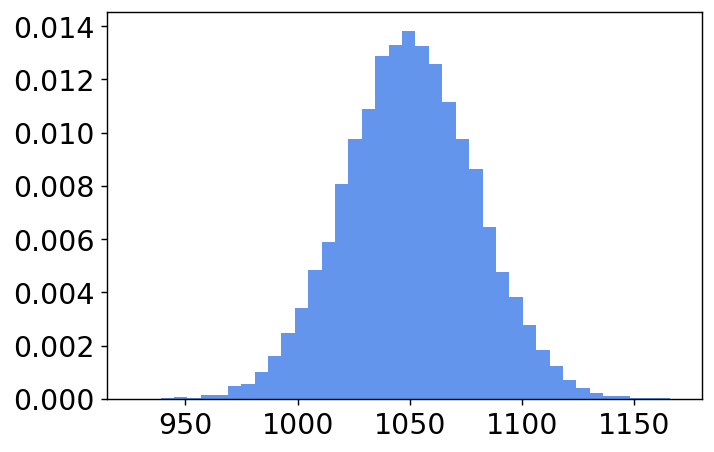

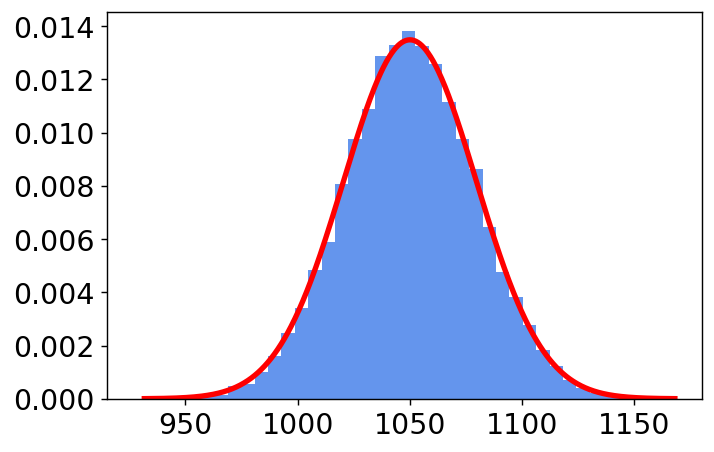

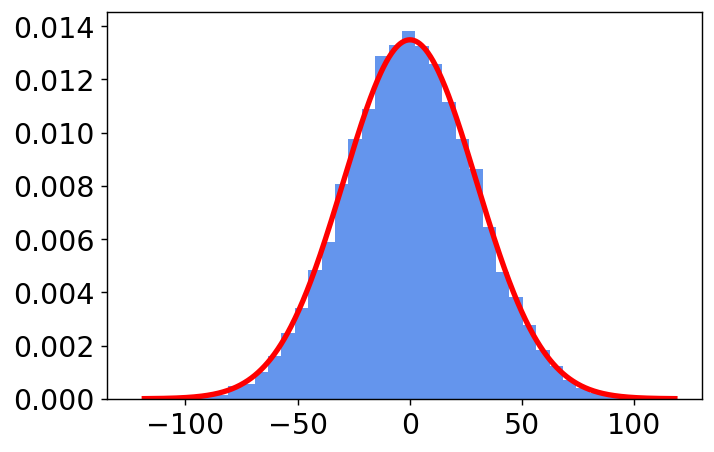

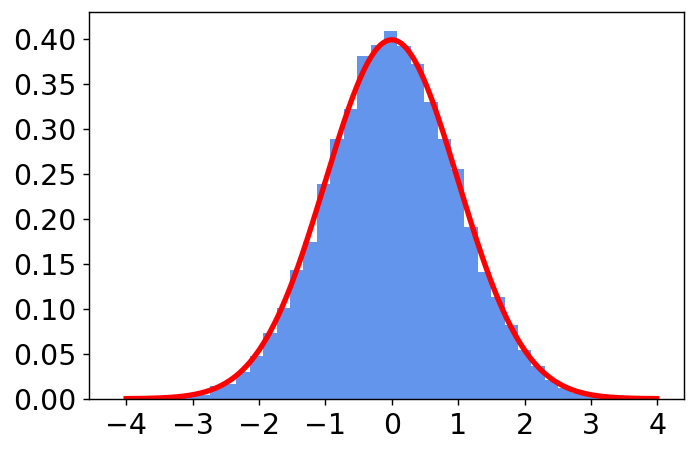

In [68]:
# グラフを描画

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

BINS = 40

# S200の割合の棒グラフ
plt.figure(0, dpi=128)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.hist(
    sums, 
    bins=BINS,
    density=True,
    color="cornflowerblue"
)

X = np.arange(-4, 4, 0.01)
plt.plot(
    X * math.sqrt(DICE_ROLLS_PER_SET * VARIANCE) + DICE_ROLLS_PER_SET * MEAN, 
    [0] * len(X),
    linewidth=0
)

# 正規分布との比較
plt.figure(1, dpi=128)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.hist(
    sums,
    bins=BINS,
    density=True,
    color="cornflowerblue"
)
X = np.arange(-4, 4, 0.01)
Y = norm.pdf(X, 0, 1)
plt.plot(
    X * math.sqrt(DICE_ROLLS_PER_SET * VARIANCE) + DICE_ROLLS_PER_SET * MEAN, 
    Y /  math.sqrt(DICE_ROLLS_PER_SET * VARIANCE),
    color="red",
    linewidth=3
)

# 期待値× 300 平行移動
pt_sums = [s - MEAN * 300 for s in sums]
plt.figure(2, dpi=128)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.hist(
    pt_sums,
    bins=BINS,
    density=True,
    color="cornflowerblue"
)
X = np.arange(-4, 4, 0.01)
Y = norm.pdf(X, 0, 1)
plt.plot(
    X * math.sqrt(DICE_ROLLS_PER_SET * VARIANCE),
    Y /  math.sqrt(DICE_ROLLS_PER_SET * VARIANCE),
    color="red",
    linewidth=3
)


# S200の割合の棒グラフを正規化する
normalized = [normalize(s, DICE_ROLLS_PER_SET) for s in sums]
plt.figure(4,  dpi=128)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.hist(
    normalized,
    bins=BINS,
    density=True,
    color="cornflowerblue"
)
plt.plot(
    X,
    Y,
    color="red",
    linewidth=3
)

In [62]:
FACTOR = math.sqrt(DICE_ROLLS_PER_SET * VARIANCE)

def count_pi2():
    sums =  [
        sum_of_dice(DICE_ROLLS_PER_SET)
        for _ in range(NUMBER_OF_SET)
    ]

    counts = {0: 0}
    for i in range(1, int(6 -MEAN) * DICE_ROLLS_PER_SET + 1):
        counts[i] = 0
        counts[-i] = 0
    
    for s in sums:
        _s = s - MEAN * DICE_ROLLS_PER_SET
        counts[_s] = counts[_s] + 1
    
    # 分母
    denom = 0
    # 分子
    numer = 0

    for k, v in counts.items():
        x = k / FACTOR
        denom = denom + math.exp(- (x ** 2))
        numer = numer + (v / NUMBER_OF_SET) * math.exp(- (x ** 2) / 2) 

    C = FACTOR * (numer / denom)

    pi = 1 / (2 * (C **2))
    return pi
    
print("円周率")

for i in range(10):
    pi = count_pi2()
    print(f"{i+1} 回目: {pi}")


円周率
1 回目: 3.132575912237684
2 回目: 3.155799880844639
3 回目: 3.1233385472535664
4 回目: 3.1509879209966254
5 回目: 3.1424303119447026
6 回目: 3.1565350489549204
7 回目: 3.1396211476730738
8 回目: 3.1271185560427592
9 回目: 3.1298832788304347
10 回目: 3.129545119919663
